In [1]:
import sys, os
import xsimlab as xs
import xarray as xa
import pandas as pd
import numpy as np
import sparse
import igraph as ig
import ipywidgets as widgets

sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab

In [2]:
from vmlab.models import fruit_model
from vmlab.processes import carbon_unit

model = fruit_model.drop_processes(['carbon_unit', 'light', 'photo', 'carbon', 'fruit_quality'])
#model = fruit_model.update_processes({ 'carbon_unit': carbon_unit.JustOne })
model

<xsimlab.Model (8 processes, 9 inputs)>
params
    path                     [in]
    seed                     [in]
env
topo
    is_apical             [inout] ('GU',) 
    adjacency             [inout] ('GU', 'GU') 
    nb_leaves_gu          [inout] ('GU',) 
pheno
    bloom_date            [inout] ('GU',) bloom date
fruit_growth
    nb_fruits_ini         [inout] ('GU',) 
inflo_growth
gu_growth
gu_burst
    gu_bursted            [inout] ('GU',) 
    gu_bursted_is_apical  [inout] ('GU',) 

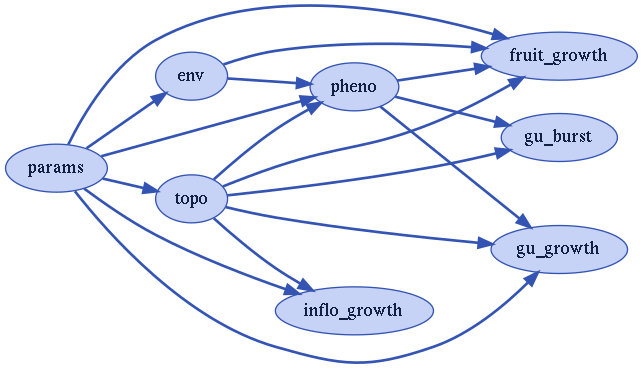

In [3]:
model.visualize(show_inputs=False, show_variables=False)

In [4]:
ds = vmlab.create_setup(
    model=model,
    clocks={
        'day': pd.date_range(start='2002-09-02', end='2003-03-28', freq="1d")
    },
    master_clock='day',
    input_vars={
        'params': {
            'seed': 0,
            'path': '../share/setup/default.toml'
        },
        'pheno': { 
            'bloom_date': [
                '2001-11-01',
                '2002-11-01',
                '2002-11-10',
                '2002-11-20',
                '2002-11-30',
                '2002-12-10',
                '2002-12-20',
            ]
        },
        'gu_burst': {
            'gu_bursted': [False, False, False, False, False, False, False],
            'gu_bursted_is_apical': [False, False, False, False, False, False, False]
        },
        'topo': {
            'adjacency': sparse.COO(np.array([
                    [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6]
                ]).transpose(), True, shape=(7, 7)),
            'is_apical': [False, False, False, True, False, False, False],
            'nb_leaves_gu': [0, 5, 10, 25, 50, 100, 150]
        },
        'fruit_growth': {
            'nb_fruits_ini': [0, 1, 1, 1, 1, 1, 1]
        }
    }
)

In [5]:
ds

Format,coo
Data Type,bool
Shape,"(7, 7)"
nnz,6
Density,0.12244897959183673
Read-only,True
Size,102
Storage ratio,2.1


In [6]:
out = widgets.Output(layout=widgets.Layout(width='100%', height='800px'))
@xs.runtime_hook('run_step')
def runtime_hook(model, context, state):
    if context['step'] % 7 == 0 or context['step'] == context['nsteps'] - 1:
        GU = state[('topo', 'GU')]
        adjacency = state[('topo', 'adjacency')]
        is_apical = state[('topo', 'is_apical')]
        gu_growth_tts = state[('pheno', 'gu_growth_tts')]
        g = ig.Graph.Adjacency(list(np.ones(adjacency.shape) * adjacency))
        l = g.layout_reingold_tilford(root=0)
        l.rotate(-90)
        style = {
            'vertex_size': 20,
            'vertex_color': 'white', # [f'{(int(t)/1000*100)+155}, 0, 0' for t in gu_growth_tts],
            'vertex_label_size': 8,
            #'vertex_label': [i for i in range(gu_growth_tts.shape[0])],
            'vertex_label': [int(t) for t in gu_growth_tts],
            'edge_arrow_size': 0,
            'edge_arrow_width': 1
        }
        with out:
            out.clear_output()
            print(context['step'] + 1, '/' ,context['nsteps'], 'GU:', GU.shape[0])
            display(ig.plot(g, layout=l, bbox = (800, 500), margin=(20, 20, 20, 20), **style))
out

Output(layout=Layout(height='800px', width='100%'))

In [7]:
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[runtime_hook])

In [8]:
ds_out

<xarray.Dataset>
Dimensions:                         (GU: 77, day: 208, hour: 24)
Coordinates:
  * GU                              (GU) <U10 'GU0' 'GU1' ... 'NEW0' 'NEW0'
  * day                             (day) datetime64[ns] 2002-09-02 ... 2003-...
  * hour                            (hour) int8 0 1 2 3 4 5 ... 19 20 21 22 23
Data variables:
    env__GR                         (day, hour) float64 0.0 0.0 0.0 ... 0.0 0.0
    env__RH                         (day, hour) float64 76.0 71.0 ... 88.0 78.0
    env__TM                         (day) float64 21.6 20.9 ... 24.85 24.85
    env__TM_air                     (day, hour) float64 20.7 20.7 ... 24.85
    env__T_air                      (day, hour) float64 17.1 17.5 ... 20.9 21.3
    env__T_fruit                    (day, hour) float64 17.1 17.5 ... 20.9 21.3
    fruit_growth__DM_fruit_0_gu     (day, GU) float64 21.38 21.38 ... 0.0 0.0
    fruit_growth__DM_fruit_max_gu   (day, GU) float64 0.0 0.0 0.0 ... 0.0 0.0
    fruit_growth__nb_fruits_gu      (day, GU) float64 0.0 0.0 0.0 ... 0.0 0.0
    fruit_growth__nb_fruits_ini     (day, GU) int64 0 1 1 1 1 1 ... 0 0 0 0 0 0
    gu_burst__gu_bursted            (day, GU) bool False False ... False False
    gu_burst__gu_bursted_is_apical  (day, GU) bool False False ... False False
    params__path                    (day) <U27 '../share/setup/default.toml' ...
    params__seed                    (day) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    pheno__DAB                      (day, GU) float64 305.0 -1.0 ... 1.214e+04
    pheno__bloom_date               (day, GU) datetime64[D] 2001-11-01 ... 19...
    pheno__dd_cum_gu                (day, GU) float64 5.6 0.0 ... 45.25 25.95
    pheno__dd_delta_gu              (day, GU) float64 5.6 0.0 0.0 ... 8.85 8.85
    pheno__gu_growth_tts            (day, GU) float64 12.4 12.4 ... 79.25 46.35
    pheno__gu_pheno_tts             (day, GU) float64 0.0 0.0 0.0 ... 0.0 0.0
    pheno__leaf_growth_tts          (day, GU) float64 10.87 10.87 ... 71.6 41.76
    topo__adjacency                 (day, GU, GU) bool False True ... False
    topo__is_apical                 (day, GU) bool False False ... True False
    topo__nb_leaves_gu              (day, GU) int64 0 5 10 25 50 ... 0 0 0 0 0

In [9]:
#ds_out.carbon_unit__dd_cum.plot.line(x='day')

In [10]:
#ds_out.plot.scatter(x='carbon_unit__dd_cum', y='carbon__DM_fruit', col='CU', col_wrap=3)

In [11]:
#ds_out.light__LFratio.plot()

In [12]:
#ds_out.carbon_unit__nb_leaves.plot()

In [13]:
#ds_out.carbon_unit__nb_fruits.plot()

